<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [455]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

df=pd.read_excel('unisim_hist-m.xlsx').iloc[1:,:]
# df=pd.read_excel('unisim_hist-m.xlsx').iloc[1:49,:]
df.head()

,Date,Press,Np,Gp,Wp,Winj
1,2013-06-30,332,0,0,0,0
2,2013-07-31,331,61938,6858068,0,0
3,2013-08-31,329,124403,13532213,0,0
4,2013-09-30,328,182423,20112443,0,0
5,2013-10-31,327,244857,26856741,0,0


In [456]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17

In [457]:
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
# df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
# df["dp"]= df["Press"].iloc[0]-df["Press"]
# df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt
128,2024-01-31,305,24757936,2793256452,4393983,36864922,3867.0,31.0
129,2024-02-29,306,25022300,2822363056,4583991,37475894,3896.0,29.0
130,2024-03-31,307,25304090,2853787229,4789676,38123794,3927.0,31.0
131,2024-04-30,308,25567400,2883725639,4991816,38702374,3957.0,30.0
132,2024-05-31,309,25832419,2913898931,5206739,39341191,3988.0,31.0


In [458]:
## PVT functions
print(Swi)
def func_bo(p, a, b):
    bo = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          bo[i] = a * p[i] + b
        else:
          bo[i] = bob - co * (p[i] - pb)
    return bo

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs = np.zeros(len(p))
    for i in range(len(p)):
      if p[i] < pb:
        rs[i] = a * p[i] + b
      else:
        rs[i] = Rsi
    return rs

0.17


In [459]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)

# df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
# df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["F"] = df["Np"]*(df["Bo"]+(df["Rp"]-df["Rs"])*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
# df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eo"] = df["Bo"]-df["Bo"].iloc[0]+(df["Rs"].iloc[0]-df["Rs"])*df["Bg"]
# df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Eg"] = df["Bo"].iloc[0]*((df["Bg"]/df["Bg"].iloc[0])-1)
# df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])
df["Efw"] = (1+m)*df["Bo"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])

df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,Bo,Bg,Rs,Rp,F,Eo,Eg,Efw
1,2013-06-30,332,0,0,0,0,0.0,0.0,1.394241,0.003315,113.06,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1.394403,0.003325,113.06,110.724725,85885.547962,0.000162,0.004391,0.000103
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,1.394727,0.003346,113.06,108.777224,171725.300945,0.000486,0.013254,0.000308
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1.394889,0.003357,113.06,110.251684,252740.020631,0.000648,0.017727,0.000410
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,1.395051,0.003368,113.06,109.683370,338803.591700,0.000810,0.022227,0.000513


In [460]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
# p_med=train["p_med"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
gp=train["Gp"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values

Estimativa de N: 183.79
Estimativa de Wi: 100.00
Estimativas de J: 100.00
desvio (MMm³): 0.2056
r²: 0.75


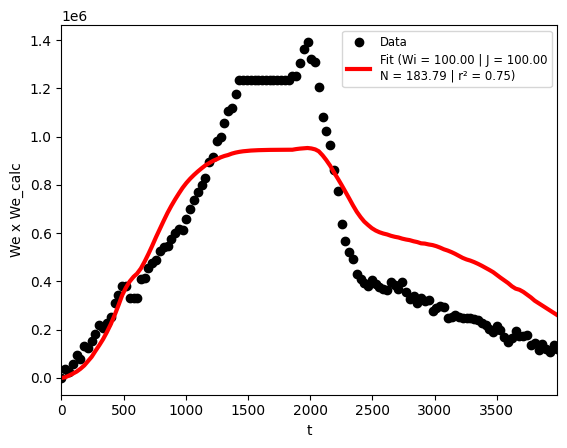

In [461]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    Wi = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wei = (cf+cw)*Wi*p[0]*10**6
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      pa_med[i-1]=p[0]*(1-(Wen[i-1]/Wei))
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
    We_EBM = F - (N*10**6) * (Eo + m * Eg + Efw)
    return np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5
    # return np.sum((We_EBM - Wen) ** 2)

# Chute inicial para N, Wi e J
x0 = np.array([130] + [100] + [10])

# Limites para N, Wi e J
bounds = [(10, 300)] + [(100, 1000)] + [(1, 100)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

N_est = result.x[0]
Wi_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est:0.2f}")
print(f"Estimativa de Wi: {Wi_est:0.2f}")
print(f"Estimativas de J: {J_est:0.2f}")

Wei_est = (cf+cw)*Wi_est*p[0]*10**6
# print(Wei_est)
Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  pa_med[i-1] = p[0]*(1-(Wen[i-1]/Wei_est))
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
pa_med[len(t)-1] = p[0]*(1-(Wen[len(t)-1]/Wei_est))
We_EBM = F - (N_est*10**6) * (Eo + m * Eg + Efw)
print(f"desvio (MMm³): {np.mean(((We_EBM - Wen)/10**6) ** 2)**0.5:0.4f}")

r2_2 = r2_score(We_EBM, Wen)
print(f"r²: {r2_2:0.2f}")

plt.scatter(t, We_EBM, label="Data", color="black")
plt.plot(t, Wen, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We x We_calc")
plt.xlim(0, df.iloc[-1, 6])
plt.show()

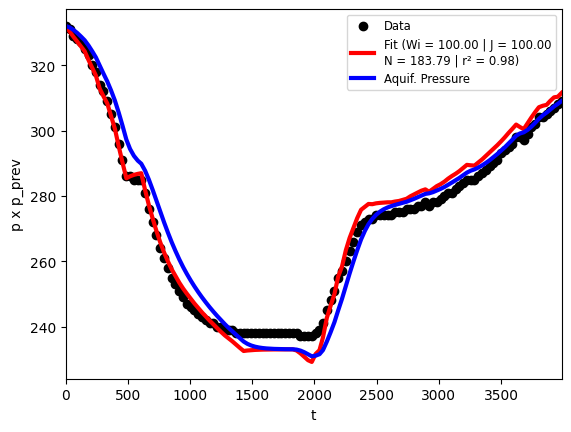

In [462]:
## Previsao de pressao

p_prev=np.zeros(len(t))
we_aquif=np.zeros(len(t))
ppa_med=np.zeros(len(t))
we_ebm=np.zeros(len(t))

for i in range(len(t)):
  if i == 0:
    p_prev[i]=p[0]
    we_aquif[i]=0
    ppa_med[i]=p[0]
    we_ebm[i]=0
  else:
    # Função objetivo
    def obj_f(x, m, N, Wei, J):
      pn = x[0]  # pressao prevista

      ## Aquifero
      ppa_med[i-1]=p[0]*(1-(we_aquif[i-1]/Wei))
      we_aquif[i]=we_aquif[i-1]+(Wei/p[0])*(ppa_med[i-1]-pn)*(1-np.exp(-J*p[0]*dt[i]/Wei))

      ## EBM
      if pn < pb:
        bop = 0.0012 * pn + 1.1538
        rsp = 0.4655 * pn + 15.0114
      else:
        bop = bob - co * (pn - pb)
        rsp = Rsi
      bgp = 1.40676*pn**(-1.04229)
      fp=npp[i]*(bop+(rp[i]-rsp)*bgp)+(wp[i]-winj[i])*Bw
      eop=bop-bo[0]+(Rsi-rsp)*bgp
      egp=bo[0]*((bgp/bg[0])-1)
      efwp=(1+m)*bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
      we_ebm[i]=fp-N*(eop+m*egp+efwp)*10**6

      return (we_ebm[i] - we_aquif[i]) ** 2

    x0 = [p_prev[i-1]]
    result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
    p_prev[i]=result.x[0]

  ppa_med[i]=p[0]*(1-(we_aquif[i]/Wei_est))

r2_2 = r2_score(p, p_prev)
# print(p_prev)

plt.scatter(t, p, label="Data", color="black")
plt.plot(t, p_prev, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.plot(t, ppa_med, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, df.iloc[-1, 6])
plt.show()

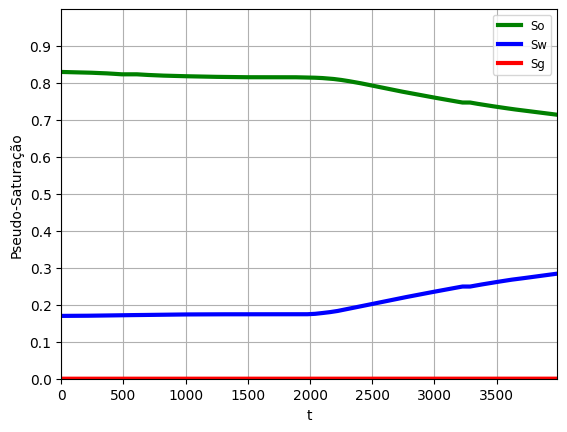

In [463]:
## Saturacoes de fluidos

So = np.zeros(len(t))
Sw = np.zeros(len(t))
Sg = np.zeros(len(t))
cct = np.zeros(len(t))
Vpp = np.zeros(len(t))
Vp = (N_est*10**6) * bo[0] / (1 - Swi)
G = ((N_est*10**6) * Rsi + m * (N_est*10**6) * bo[0] / bg[0])
# print(G)

for i in range(len(t)):
  cct[i] = (1 + (Swi * cw / (1 - Swi) + cf) * (p[i] - p[0]))
  Vpp[i] = Vp * (1 + cf * (p[i] - p[0]))
  So[i] = ((N_est*10**6) - npp[i]) *bo[0] / Vpp[i]
  Sw[i] = (Swi * Vp * (1 - cw * (p[i] - p[0])) + ((winj[i] - wp[i] + Wen[i]) * Bw)) / Vpp[i]
  Sg[i] = bg[i] * (G - gp[i] - ((N_est*10**6) - npp[i]) * rs[i] - cct[i] * m * (N_est*10**6) * bo[0] / bg[0]) / Vpp[i]

# print(Sg)
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()
plt.plot(t, So, label="So", color="green", linewidth=3)
plt.plot(t, Sw, label="Sw", color="blue", linewidth=3)
plt.plot(t, Sg, label="Sg", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, df.iloc[-1, 6])
plt.show()

In [464]:
date=df["Date"].values
date_time=pd.to_datetime(date)
date_time

DatetimeIndex(['2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', length=132, freq=None)

In [465]:
from pandas.tseries.offsets import MonthEnd

# Última data fornecida
last_date = date_time[-1]

# Quantidade de meses na previsão
n_months = 120

# Gerar novas datas, no último dia de cada mês seguinte
new_dates = pd.to_datetime([last_date + MonthEnd(n) for n in range(1, n_months+1)])
new_dates

# (new_dates[0]-date_time[-1]).days

DatetimeIndex(['2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30',
               '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
               '2025-02-28', '2025-03-31',
               ...
               '2033-08-31', '2033-09-30', '2033-10-31', '2033-11-30',
               '2033-12-31', '2034-01-31', '2034-02-28', '2034-03-31',
               '2034-04-30', '2034-05-31'],
              dtype='datetime64[ns]', length=120, freq=None)

In [466]:
## Forecast

fc = pd.DataFrame(new_dates, columns=['Date'])
fc = pd.concat([df, fc], ignore_index=True).iloc[:,:7].fillna(0)
fc["t"] = (fc["Date"]-fc["Date"].iloc[0]).astype("int64")/10**9/60/60/24
fc["dt"]=fc["t"].diff().fillna(0)
fc

,Date,Press,Np,Gp,Wp,Winj,t,dt
0,2013-06-30,332.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-07-31,331.0,61938.0,6858068.0,0.0,0.0,31.0,31.0
2,2013-08-31,329.0,124403.0,13532213.0,0.0,0.0,62.0,31.0
3,2013-09-30,328.0,182423.0,20112443.0,0.0,0.0,92.0,30.0
4,2013-10-31,327.0,244857.0,26856741.0,0.0,0.0,123.0,31.0
...,...,...,...,...,...,...,...,...
247,2034-01-31,0.0,0.0,0.0,0.0,0.0,7520.0,31.0
248,2034-02-28,0.0,0.0,0.0,0.0,0.0,7548.0,28.0
249,2034-03-31,0.0,0.0,0.0,0.0,0.0,7579.0,31.0
250,2034-04-30,0.0,0.0,0.0,0.0,0.0,7609.0,30.0


In [467]:
# fc.iloc[-1, 1] = "Novo valor"
# fc
# fc.shape[0]
fc.iloc[-1, 6]

7640.0

In [468]:
for i in range(fc.shape[0]-df.shape[0]):
  # print(i)
  for j in range(2,6):
    if j == 5:
      fc.iloc[df.shape[0]+i, j] = fc.iloc[df.shape[0]+i-1, j]*1.015
    else:
      fc.iloc[df.shape[0]+i, j] = fc.iloc[df.shape[0]+i-1, j]**2/fc.iloc[df.shape[0]+i-2, j]

fc["Rp"] = (fc["Gp"]/fc["Np"]).fillna(0)
fc

,Date,Press,Np,Gp,Wp,Winj,t,dt,Rp
0,2013-06-30,332.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000
1,2013-07-31,331.0,6.193800e+04,6.858068e+06,0.000000e+00,0.000000e+00,31.0,31.0,110.724725
2,2013-08-31,329.0,1.244030e+05,1.353221e+07,0.000000e+00,0.000000e+00,62.0,31.0,108.777224
3,2013-09-30,328.0,1.824230e+05,2.011244e+07,0.000000e+00,0.000000e+00,92.0,30.0,110.251684
4,2013-10-31,327.0,2.448570e+05,2.685674e+07,0.000000e+00,0.000000e+00,123.0,31.0,109.683370
...,...,...,...,...,...,...,...,...,...
247,2034-01-31,0.0,8.544217e+07,9.746703e+09,6.921585e+08,2.212628e+08,7520.0,31.0,114.073687
248,2034-02-28,0.0,8.632782e+07,9.848686e+09,7.219595e+08,2.245817e+08,7548.0,28.0,114.084729
249,2034-03-31,0.0,8.722265e+07,9.951736e+09,7.530435e+08,2.279505e+08,7579.0,31.0,114.095772
250,2034-04-30,0.0,8.812676e+07,1.005586e+10,7.854658e+08,2.313697e+08,7609.0,30.0,114.106815


In [469]:
train_fc = fc.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p_fc=train_fc["Press"].values
t_fc=train_fc["t"].values
dt_fc=train_fc["dt"].values
npp_fc=train_fc["Np"].values
gp_fc=train_fc["Gp"].values
rp_fc=train_fc["Rp"].values
wp_fc=train_fc["Wp"].values
winj_fc=train_fc["Winj"].values
rp_fc=((train_fc["Gp"]/train_fc["Np"]).fillna(0)).values

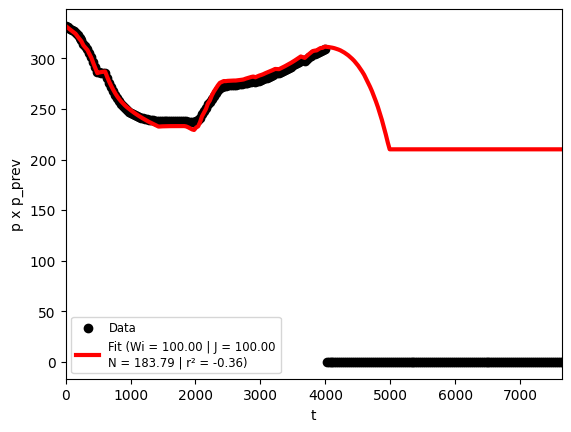

In [470]:
## Previsao de pressao

p_prev_fc=np.zeros(len(t_fc))
we_aquif_fc=np.zeros(len(t_fc))
ppa_med_fc=np.zeros(len(t_fc))
we_ebm_fc=np.zeros(len(t_fc))

for i in range(len(t_fc)):
  if i == 0:
    p_prev_fc[i]=p[0]
    we_aquif_fc[i]=0
    ppa_med_fc[i]=p[0]
    we_ebm_fc[i]=0
  else:
    # Função objetivo
    def obj_f(x, m, N, Wei, J):
      pn = x[0]  # pressao prevista

      ## Aquifero
      ppa_med_fc[i-1]=p[0]*(1-(we_aquif_fc[i-1]/Wei))
      we_aquif_fc[i]=we_aquif_fc[i-1]+(Wei/p[0])*(ppa_med_fc[i-1]-pn)*(1-np.exp(-J*p[0]*dt_fc[i]/Wei))

      ## EBM
      if pn < pb:
        bop = 0.0012 * pn + 1.1538
        rsp = 0.4655 * pn + 15.0114
      else:
        bop = bob - co * (pn - pb)
        rsp = Rsi

      bgp = 1.40676*pn**(-1.04229)
      fp=npp_fc[i]*(bop+(rp_fc[i]-rsp)*bgp)+(wp_fc[i]-winj_fc[i])*Bw
      eop=bop-bo[0]+(Rsi-rsp)*bgp
      egp=bo[0]*((bgp/bg[0])-1)
      efwp=(1+m)*bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
      we_ebm_fc[i]=fp-N*(eop+m*egp+efwp)*10**6

      return (we_ebm_fc[i] - we_aquif_fc[i]) ** 2

    x0 = [p_prev_fc[i-1]]
    result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
    p_prev_fc[i]=result.x[0]

  ppa_med_fc[i]=p[0]*(1-(we_aquif_fc[i]/Wei_est))

r2_2 = r2_score(p_fc, p_prev_fc)
# print(p_prev_fc)

plt.scatter(t_fc, p_fc, label="Data", color="black")
plt.plot(t_fc, p_prev_fc, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
# plt.plot(t_fc, ppa_med_fc, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, fc.iloc[-1, 6])
plt.show()

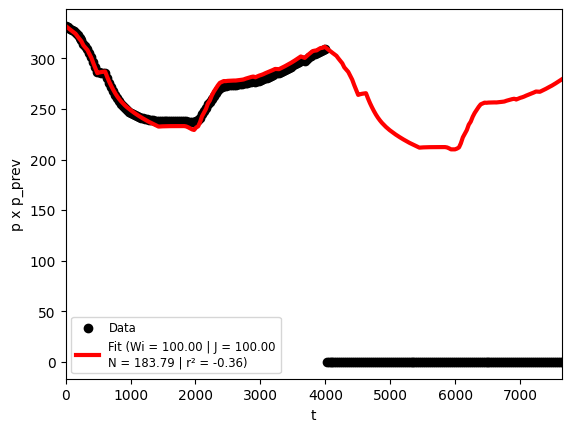

In [471]:
## Previsao de pressao 2

p_prev_fc=np.zeros(n_months)
we_aquif_fc=np.zeros(n_months)
ppa_med_fc=np.zeros(n_months)
we_ebm_fc=np.zeros(n_months)

for i in range(n_months):
  if i == 0:
    x0 = [p_prev[-1]]
    we_aquif_fc[i]=we_aquif[-1]
    we_ebm_fc[i]=we_ebm[-1]
  if i > 0:
    x0 = [p_prev_fc[i-1]]

  # Função objetivo
  def obj_f(x, m, N, Wei, J):
    pn = x[0]  # pressao prevista

    ## Aquifero
    ppa_med_fc[i-1]=p_prev[-1]*(1-(we_aquif_fc[i-1]/Wei))
    we_aquif_fc[i]=we_aquif_fc[i-1]+(Wei/p_prev[-1])*(ppa_med_fc[i-1]-pn)*(1-np.exp(-J*p_prev[-1]*dt_fc[i]/Wei))

    ## EBM
    if pn < pb:
      bop = 1.40676 * pn - 1.04229
      rsp = 0.4655 * pn + 15.0114
    else:
      bop = bob - co * (pn - pb)
      rsp = Rsi
    bgp = 1.40676*pn**(-1.04229)
    fp=npp_fc[i]*(bop+(rp_fc[i]-rsp)*bgp)+(wp_fc[i]-winj_fc[i])*Bw
    eop=bop-bo[-1]+(Rsi-rsp)*bgp
    egp=bo[-1]*((bgp/bg[-1])-1)
    efwp=(1+m)*bo[-1]*((cf+cw*Swi)/(1-Swi))*(p_prev[-1]-pn)
    we_ebm_fc[i]=fp-N*(eop+m*egp+efwp)*10**6

    return (we_ebm_fc[i] - we_aquif_fc[i]) ** 2

  result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
  p_prev_fc[i]=result.x[0]

# r2_2 = r2_score(p_fc, p_prev_fc)
p_prev_f = np.concatenate((p_prev, p_prev_fc))
# print(p_prev_fc)

plt.scatter(t_fc, p_fc, label="Data", color="black")
plt.plot(t_fc, p_prev_f, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
# plt.plot(t, pa_med, label="Aquif. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, fc.iloc[-1, 6])
plt.show()

In [472]:
# fc["Press"]=p_prev_f
# fc